<a href="https://colab.research.google.com/github/mzsolt68/DogVision/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog Breed Classification (v2)

Building an end-to-end multi-class image classifier using TensorFlow

## 1. Problem

Identifying the breed of a dog from a given image

## 2. Data

We're going to use the Stanford Dogs dataset, which is available from several sources:
* The original project website: http://vision.stanford.edu/aditya86/ImageNetDogs/
* Inside the Tensorflow datasets: https://www.tensorflow.org/datasets/catalog/stanford_dogs
* On Kaggle: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

## 3. Using the data

To make sure we don't have to download the data every time we come back to Colab:
* Download the data to the attached Google Drive if it doesn't already exists
* Copy the data to the Google drive if it isn't already there
* If the data already exists on Google Drive We'll import it

## 4. Features

Some information about the data:
* We are dealing with unstructured data (images), so it is probably best we use deeep learning/transfer learning.
* There are 120 breeds of dogs, this means there are 120 different classes).
* Around 10,000+ images in the training set (these images have labels)
* Around 10,000+ images in the test set


In [1]:
# Quick timestamp
import datetime
print(f"Notebook last run: {datetime.datetime.now()}")

Notebook last run: 2025-05-10 16:15:56.904158


In [2]:
# Import TensorFlow and check if we have GPU access
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

device_list = tf.config.list_physical_devices()
if "GPU" in [device.device_type for device in device_list]:
  print(f"[INFO] TensorFlow has GPU available to use.")
  print(f"[INFO] Accessible devices:\n{device_list}")
else:
  print(f"[INFO] TensorFlow does not have GPU available to use. Models may take a while to train.")
  print(f"[INFO] Accessible devices:\n{device_list}")

TensorFlow version: 2.18.0
[INFO] TensorFlow has GPU available to use.
[INFO] Accessible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Getting the data
Check if the target files exist in Google Drive and copy them to Colab. If the files doesn't exist, download them.

In [3]:
from pathlib import Path
from google.colab import drive

# 1. Mount Google Drive (this will bring up a pop-up to sign-in/authenticate)
# Note: This step is specifically for Google Colab, if you're working locally, you may need a different setup
# drive.mount("/content/drive")

# 2. Setup constants
# Note: For constants like this, you'll often see them created as variables with all capitals
TARGET_DRIVE_PATH = Path("drive/MyDrive/Dog_Vision/Data")
TARGET_FILES = ["images.tar", "annotation.tar", "lists.tar"]
TARGET_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs"

# 3. Setup local path
local_dir = Path("dog_vision_data")

# 4. Check if the target files exist in Google Drive, if so, copy them to Google Colab
if all((TARGET_DRIVE_PATH / file).is_file() for file in TARGET_FILES):
  print(f"[INFO] Copying Dog Vision files from Google Drive to local directory...")
  print(f"[INFO] Source dir: {TARGET_DRIVE_PATH} -> Target dir: {local_dir}")
  !cp -r {TARGET_DRIVE_PATH} {local_dir}
  print("[INFO] Good to go!")

else:
  # 5. If the files don't exist in Google Drive, download them
  print(f"[INFO] Target files not found in Google Drive.")
  print(f"[INFO] Downloading the target files... this shouldn't take too long...")
  for file in TARGET_FILES:
    # wget is short for "world wide web get", as in "get a file from the web"
    # -nc or --no-clobber = don't download files that already exist locally
    # -P = save the target file to a specified prefix, in our case, local_dir
    !wget -nc {TARGET_URL}/{file} -P {local_dir} # the "!" means to execute the command on the command line rather than in Python

  print(f"[INFO] Saving the target files to Google Drive, so they can be loaded later...")

  # 6. Ensure target directory in Google Drive exists
  TARGET_DRIVE_PATH.mkdir(parents=True, exist_ok=True)

  # 7. Copy downloaded files to Google Drive (so we can use them later and not have to re-download them)
  !cp -r {local_dir}/* {TARGET_DRIVE_PATH}/

[INFO] Copying Dog Vision files from Google Drive to local directory...
[INFO] Source dir: drive/MyDrive/Dog_Vision/Data -> Target dir: dog_vision_data
[INFO] Good to go!


In [4]:
# Make sure the files are exist
if local_dir.exists():
  print(str(local_dir) + "/")
  for item in local_dir.iterdir():
    print("  ", item.name)

dog_vision_data/
   annotation.tar
   lists.tar
   images.tar


In [5]:
# Untar the images, notes/tags
!tar -xf {local_dir}/images.tar -C {local_dir}
!tar -xf {local_dir}/annotation.tar -C {local_dir}
!tar -xf {local_dir}/lists.tar -C {local_dir}


We've got some new files.
Specifically:

* `train_list.mat` - a list of all the training set images.
* `test_list.mat` - a list of all the testing set images.
* `Images/` - a folder containing all of the images of dogs.
* `Annotation/` - a folder containing all of the annotations for each image.
* `file_list.mat` - a list of all the files (training and test list combined).


### Exploring the data
Before we build a model, it's good to explore the data to see what kind of data we're working with. For example:
* **Check at least 100+ random samples** if you have a large dataset.
* **Visualize!**
* **Check the distribution and other statistics.** How many samples are there? In a classification problem, how many classes and labels per class are there? etc.

#### Exploring the files lists

In [6]:
# Open the MATLAB files
import scipy

# Open lists of train and test .mat
train_list = scipy.io.loadmat(Path(local_dir, "train_list.mat"))
test_list = scipy.io.loadmat(Path(local_dir, "test_list.mat"))
file_list = scipy.io.loadmat(Path(local_dir, "file_list.mat"))

# Let's inspect the output and type of the train_list
train_list, type(train_list)

({'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct  9 08:36:13 2011',
  '__version__': '1.0',
  '__globals__': [],
  'file_list': array([[array(['n02085620-Chihuahua/n02085620_5927.jpg'], dtype='<U38')],
         [array(['n02085620-Chihuahua/n02085620_4441.jpg'], dtype='<U38')],
         [array(['n02085620-Chihuahua/n02085620_1502.jpg'], dtype='<U38')],
         ...,
         [array(['n02116738-African_hunting_dog/n02116738_6754.jpg'], dtype='<U48')],
         [array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')],
         [array(['n02116738-African_hunting_dog/n02116738_2503.jpg'], dtype='<U48')]],
        dtype=object),
  'annotation_list': array([[array(['n02085620-Chihuahua/n02085620_5927'], dtype='<U34')],
         [array(['n02085620-Chihuahua/n02085620_4441'], dtype='<U34')],
         [array(['n02085620-Chihuahua/n02085620_1502'], dtype='<U34')],
         ...,
         [array(['n02116738-African_hunting_dog/n02116738_6754'], dtype=

In [7]:
# Check out the keys of the train_list dictionary
train_list.keys()

dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])

In [8]:
# Check the length of the file_list key
print(f"Number of files in training list: {len(train_list['file_list'])}")
print(f"Number of files in testing list: {len(test_list['file_list'])}")
print(f"Number of files in full list: {len(file_list['file_list'])}")

Number of files in training list: 12000
Number of files in testing list: 8580
Number of files in full list: 20580


We have 20580 images total splitted in 60/40 ratio between train and test.

In [9]:
# Inspect the file_list key more
train_list['file_list']


array([[array(['n02085620-Chihuahua/n02085620_5927.jpg'], dtype='<U38')],
       [array(['n02085620-Chihuahua/n02085620_4441.jpg'], dtype='<U38')],
       [array(['n02085620-Chihuahua/n02085620_1502.jpg'], dtype='<U38')],
       ...,
       [array(['n02116738-African_hunting_dog/n02116738_6754.jpg'], dtype='<U48')],
       [array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')],
       [array(['n02116738-African_hunting_dog/n02116738_2503.jpg'], dtype='<U48')]],
      dtype=object)

In [10]:
# Get a single filename
train_list['file_list'][0][0][0]

np.str_('n02085620-Chihuahua/n02085620_5927.jpg')

In [11]:
# Get a Python list of all file names for each list
train_file_list = list([item[0][0] for item in train_list["file_list"]])
test_file_list = list([item[0][0] for item in test_list["file_list"]])
full_file_list = list([item[0][0] for item in file_list["file_list"]])

len(train_file_list), len(test_file_list), len(full_file_list)

(12000, 8580, 20580)

In [12]:
# Get some random samples
import random

random.sample(train_file_list, k=10)

[np.str_('n02087394-Rhodesian_ridgeback/n02087394_909.jpg'),
 np.str_('n02108089-boxer/n02108089_5753.jpg'),
 np.str_('n02106166-Border_collie/n02106166_5607.jpg'),
 np.str_('n02092339-Weimaraner/n02092339_7959.jpg'),
 np.str_('n02100877-Irish_setter/n02100877_3056.jpg'),
 np.str_('n02111129-Leonberg/n02111129_861.jpg'),
 np.str_('n02116738-African_hunting_dog/n02116738_3365.jpg'),
 np.str_('n02109961-Eskimo_dog/n02109961_4157.jpg'),
 np.str_('n02110806-basenji/n02110806_884.jpg'),
 np.str_('n02116738-African_hunting_dog/n02116738_4796.jpg')]

Make sure that the training set and the test set doesn't have common items

In [13]:
# How many files in the training set intersect with the testing set?
len(set(train_file_list).intersection(test_file_list))

0

#### Exploring the Annotation folder

In [16]:
import os

os.listdir(f"{local_dir}/Annotation")[:10]

['n02091244-Ibizan_hound',
 'n02109961-Eskimo_dog',
 'n02099429-curly-coated_retriever',
 'n02101388-Brittany_spaniel',
 'n02102177-Welsh_springer_spaniel',
 'n02093256-Staffordshire_bullterrier',
 'n02098286-West_Highland_white_terrier',
 'n02100735-English_setter',
 'n02102973-Irish_water_spaniel',
 'n02095889-Sealyham_terrier']

There are directories with dog breed names with several numbered files inside.
Each of the numbered files contains a HTML version.
For example, `Annotation/n02085620-Chihuahua/n02085620_10074`:

```
<annotation>
	<folder>02085620</folder>
	<filename>n02085620_10074</filename>
	<source>
		<database>ImageNet database</database>
	</source>
	<size>
		<width>333</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<segment>0</segment>
	<object>
		<name>Chihuahua</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>25</xmin>
			<ymin>10</ymin>
			<xmax>276</xmax>
			<ymax>498</ymax>
		</bndbox>
	</object>
</annotation>
```

The fields include the name and the size of the image, the label of the object, and where it is insid ethe image (bounding box).

Write e function to check the number of subfolders inside the `Annotation` folder (there should be 120 subfolder, one for each dog breed).

In [19]:
from pathlib import Path

def count_subfolders(path: str) -> int:
  """
    Count the number of subfolders in a given directory.

    Args:
    path (str): The path to the directory in which to count subfolders.

    Returns:
    int: The number of subfolders in the specified directory.

    Examples:
    >>> count_subfolders('/path/to/directory')
    3  # if there are 3 subfolders in the specified directory
  """
  return len([item for item in Path(path).iterdir() if item.is_dir()])

annotation_path = f"{local_dir}/Annotation"
folder_count = count_subfolders(annotation_path)
print(f"Number of subfolders in {annotation_path}: {folder_count}")

Number of subfolders in dog_vision_data/Annotation: 120


There are 120 subfolder of annotations, one for each class of dog.

But it looks like the class names are already in the filepaths.

In [20]:
# View a single training file pathname
train_file_list[0]

np.str_('n02085620-Chihuahua/n02085620_5927.jpg')

So we know, that image `n02085620_5927.jpg` should contain a `Chihuahua`.
Let's check.

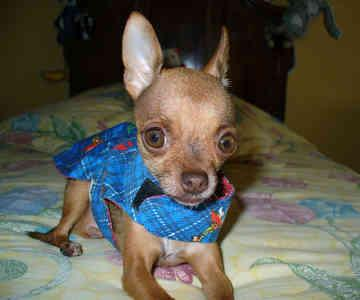

In [21]:
from IPython.display import Image
Image(Path(f"{local_dir}/Images/", train_file_list[0]))

#### Exploring the Images folder

We know that the image file names come in the format `class_name/image_name`, for example, `n02085620-Chihuahua/n02085620_5927.jpg`.

To make things a little simpler, let's create the following:

1. A mapping from folder name -> class name in dictionary form, for example, `{'n02113712-miniature_poodle': 'miniature_poodle',  'n02092339-Weimaraner': 'weimaraner',  'n02093991-Irish_terrier': 'irish_terrier'...}`. This will help us when visualizing our data from its original folder.
2. A list of all unique dog class names with simple formatting, for example, `['affenpinscher',  'afghan_hound',  'african_hunting_dog',  'airedale',  'american_staffordshire_terrier'...]`.


In [22]:
# Get a list of all image folders
image_folders = os.listdir(f"{local_dir}/Images")
image_folders[:10]

['n02091244-Ibizan_hound',
 'n02109961-Eskimo_dog',
 'n02099429-curly-coated_retriever',
 'n02101388-Brittany_spaniel',
 'n02102177-Welsh_springer_spaniel',
 'n02093256-Staffordshire_bullterrier',
 'n02098286-West_Highland_white_terrier',
 'n02100735-English_setter',
 'n02102973-Irish_water_spaniel',
 'n02095889-Sealyham_terrier']

In [23]:
# Create a foldername -> class name dictionary
folder_to_class_dictionary = {}
for folder_name in image_folders:
  class_name = folder_name.split("-")[1].lower().replace("_", " ")
  folder_to_class_dictionary[folder_name] = class_name

# Make sure there are 120 entries in the dictionary
assert len(folder_to_class_dictionary) == 120

In [24]:
list(folder_to_class_dictionary.items())[:10]

[('n02091244-Ibizan_hound', 'ibizan hound'),
 ('n02109961-Eskimo_dog', 'eskimo dog'),
 ('n02099429-curly-coated_retriever', 'curly'),
 ('n02101388-Brittany_spaniel', 'brittany spaniel'),
 ('n02102177-Welsh_springer_spaniel', 'welsh springer spaniel'),
 ('n02093256-Staffordshire_bullterrier', 'staffordshire bullterrier'),
 ('n02098286-West_Highland_white_terrier', 'west highland white terrier'),
 ('n02100735-English_setter', 'english setter'),
 ('n02102973-Irish_water_spaniel', 'irish water spaniel'),
 ('n02095889-Sealyham_terrier', 'sealyham terrier')]

In [25]:
# Get a list of unique dog names
dog_names = sorted(list(set(folder_to_class_dictionary.values())))
dog_names[:10]

['affenpinscher',
 'afghan hound',
 'african hunting dog',
 'airedale',
 'american staffordshire terrier',
 'appenzeller',
 'australian terrier',
 'basenji',
 'basset',
 'beagle']

Now we've got:
- a mapping from a folder name to a class name: `folder_to_class_dictionary`
- a list of unique dog breeds: `dog_names`

#### Visualize a group of random images

Create a function that takes a list of image paths and randomly selects 10 paths to display.
The function will:
1. Take a list of image paths as input.
2. Creat a grid of Matplotlib plots (e.g. 2x5)
3. Using `random.sample()`, selects 10 image paths from the input list.
4. Iterate through the flattened axes via `axes.flat` which is a reference to the attribute `numpy.ndarray.flat`.
5. Extract the sample path from the list of samples.
6. Get the sample title from the parent folder of the path using `Path.parent.stem` and then extract the formatted dog breed name by indexing `folder_to_class_name_dict`.
7. Read the image with `plt.imread()` and show it on the target ax with `ax.imshow()`.
8. Set the title of the plot to the parent folder name with `ax.set_title()` and turn the axis marks of with `ax.axis("off")` (this makes for pretty plots).
9. Show the plot with `plt.show()`.

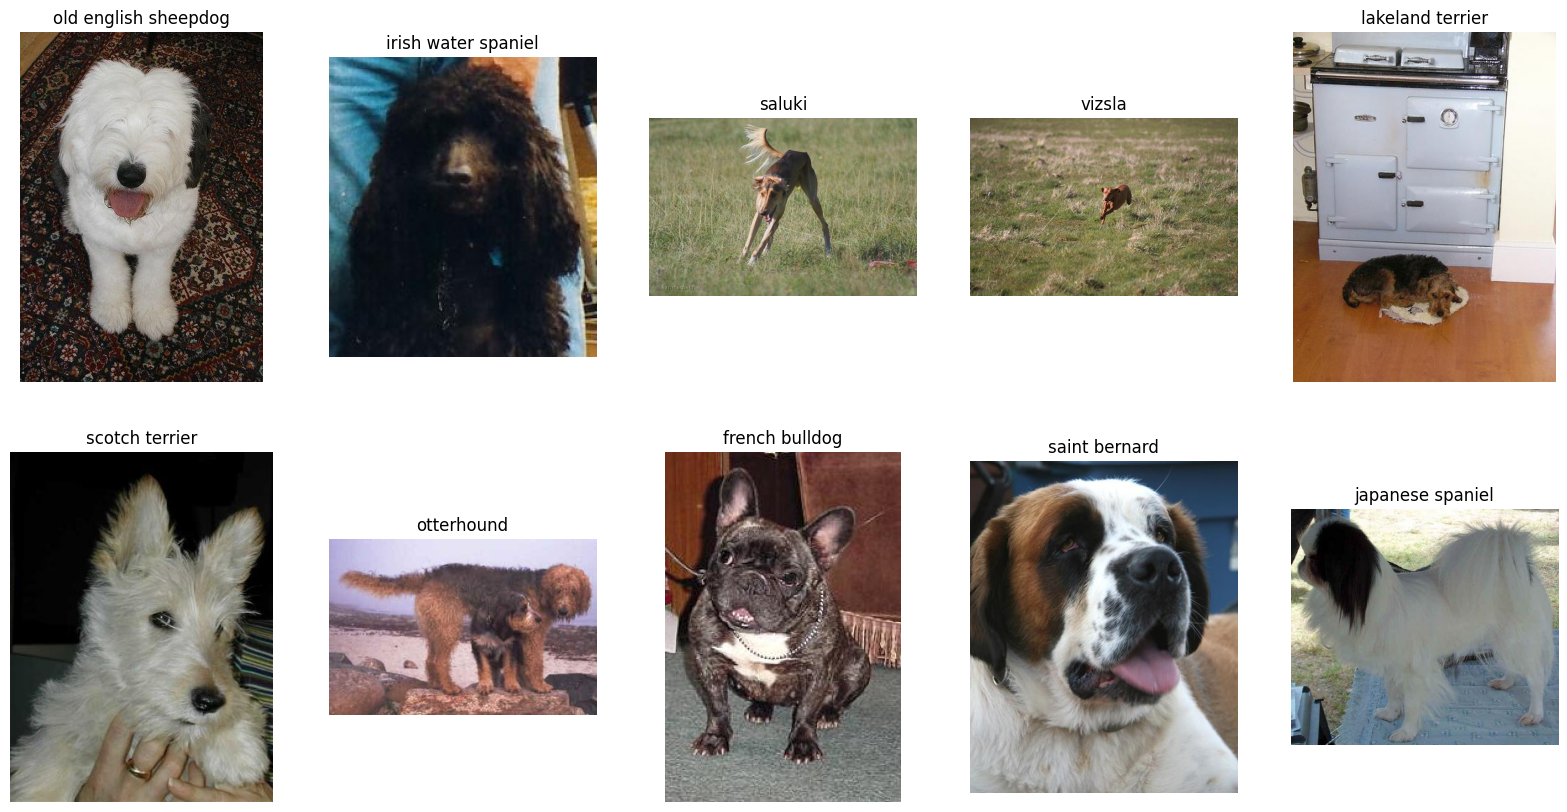

In [28]:
import random
from pathlib import Path
from typing import List
import matplotlib.pyplot as plt

def plot_10_random_images(image_paths: List[Path], extract_title: bool = True) -> None:
  """
    Plots 10 random images from a list of image paths.

    Args:
    image_paths (List[Path]): A list of image paths to plot.
    extract_title (bool): Whether to extract the title from the image path

    Returns:
    None
  """
  # Setup a grid of plots
  fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))

  # Get a list of random image paths
  samples = random.sample(image_paths, k=10)

  # Iterate through the flattened axes and corresponding image paths
  for i, ax in enumerate(axes.flat):
    # Get the image path
    image_path = samples[i]
    # Extract the parent directory name to use as the title (if neccesary)
    if extract_title:
      title = folder_to_class_dictionary[image_path.parent.stem]
    else:
      title = image_path.parent.stem

    # Read the image
    ax.imshow(plt.imread(image_path))
    # Set the title
    ax.set_title(title)
    # Turn the axis off
    ax.axis("off")

  # Show the plot
  plt.show()

plot_10_random_images(image_paths=[Path(f"{local_dir}/Images/") / path for path in train_file_list])
